In [1]:
import numpy as np
import tifffile
import glob
import pandas
import matplotlib.pyplot as plt

import griottes
import griottes.analyse
import griottes.graphmaker
from griottes.graphmaker import make_spheroids
from griottes.graphmaker import graph_generation_func
from griottes.graphplotter import graph_plot

## Measuring the spheroid properties

Here we introduce the first function from the [SCASC library](https://gitlab.pasteur.fr/gronteix1/spheroid-graphs). The role of this function is to analyze the labeled image `labeled_image`. 

You can download a sample image named `sample_image.tiff` from [here](https://drive.google.com/file/d/1XBxLsltppXR-1uRSej1gLtQ_gmXITEd1/view?usp=sharing) and place it into the current folder. Please feel free to contact the repository maintainer if you encounter an issue.

The options are as follows:

 - **`nuclei_channel`**: segmented image channel number
 - **`analyze_fluo_channels`**: extract info from other fluorescence channels
 - **`fluo_channel_analysis_method`**: choose from `basic`, `local_sphere` or `local_voronoi`. In the latter two cases the maximum cell radius is determined by the `radius` option.
 - **`cell_geometry_properties`**: measure the nuclei geometry properties (orientation, eccentricity)
 - **`radius`**: maximum cell radius (in px)
 - **`labeled_voronoi_tesselation`**: only applicable if `fluo_channel_analysis_method` is `basic`. Returns a labeled mask delimiting the Vornoi tiles of the tissue.
 - **`percentile`**: percentile in intensity distribution of the pixels within the detected cell volume
 - **`min_area`**: minimum nuclei volume

The example image you have downloaded above is a 3D multi-channel image where the 4th channel corresponds to the mask labels designating individual cells. The current library is made to work on 2D and 3D images, with and without the fluorescence channels in the image. The only key criterion is that the channels are ordered in the following order: **Z,X,Y,C**. For example, let's extract the cell positions from a 2D image:

In [2]:
labeled_image = tifffile.imread('sample_image.tiff')
labeled_image = labeled_image[2,...]

The image is a multi-channel marking for specific biologically relevant markers.

Text(0.5, 1.0, 'labels')

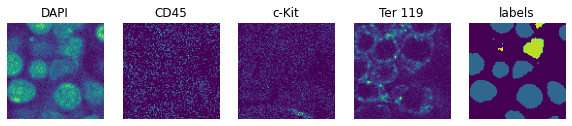

In [3]:
fig, ax = plt.subplots(1,5, figsize = (10,3))

ax[0].imshow(labeled_image[...,0])
ax[0].axis('off')
ax[0].set_title('DAPI')

ax[1].imshow(labeled_image[...,1])
ax[1].axis('off')
ax[1].set_title('CD45')

ax[2].imshow(labeled_image[...,2])
ax[2].axis('off')
ax[2].set_title('c-Kit')

ax[3].imshow(labeled_image[...,3])
ax[3].axis('off')
ax[3].set_title('Ter 119')

ax[4].imshow(labeled_image[...,4])
ax[4].axis('off')
ax[4].set_title('labels')


In [4]:
prop_2D = griottes.analyse.cell_property_extraction.get_cell_properties(
    labeled_image,
    mask_channel = 4,
    analyze_fluo_channels = True,
    fluo_channel_analysis_method = 'basic',
    radius = 30,
    min_area = 50,
    ndim = 2
    )

nuclei properties extracted


We can also extract more complex pieces of information from the images. Here for example we build a voronoi tesselation separating the volume into different regions for each cell on a 3D image. We also extract the intensities from inside the regions and the geometric properties of the cell nuclei.

In [5]:
labeled_image = tifffile.imread('sample_image.tiff')

prop_vor, vor = griottes.analyse.cell_property_extraction.get_cell_properties(
    labeled_image,
    mask_channel = 3,
    analyze_fluo_channels = True,
    fluo_channel_analysis_method = 'local_voronoi',
    cell_geometry_properties = True,
    radius = 30,
    labeled_voronoi_tesselation = True,
    percentile = 95,
    min_area = 50
    )

 21%|██▏       | 24/112 [00:00<00:00, 238.79it/s]

nuclei properties extracted
Calculating geometrical properties


16it [00:00, 128.85it/s]                          

Done geometrical properties
Calculating voronoi


112it [00:00, 120.69it/s]
0it [00:00, ?it/s]/Users/gustaveronteix/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gustaveronteix/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
112it [00:00, 480.11it/s]
112it [00:00, 659.61it/s]
112it [00:00, 660.79it/s]
112it [00:00, 649.55it/s]


In [6]:
prop_vor.columns

Index(['z', 'x', 'y', 'area', 'label', 'vec_0', 'vec_1', 'vec_2', 'theta',
       'psi', 'eccentricity', 'percentile_intensity', 'mean_intensity_0',
       'percentile_intensity_0', 'mean_intensity_1', 'percentile_intensity_1',
       'mean_intensity_2', 'percentile_intensity_2', 'mean_intensity_4',
       'percentile_intensity_4'],
      dtype='object')

## Building the tissue graph from the data

We now introduce the second pillar from the [Griottes library](https://gitlab.pasteur.fr/gronteix1/spheroid-graphs). The goal is now to build a `networkx` object `G` that is the graph representing the tissue proper.
 
### Constructing the spheroid graph

This function is used to construct the proper NetworkX object. The `generate_voronoi_graph` function takes three entries:

 - **`user_entry`**: this can be either an np.ndarray object representing a mask image, or a pandas.DataFrame containing the information for all the cells.
 - **`cell_descriptors`** (optional): a list of properties we want to attribute to each cell. Must be contained in the `data_array` columns.
 - **`dCells`** (optional): the maximum distance between two cells for them to be neighbors (in px).
 - **`flat_image`** (optional): takes value `True` if the image is 2D.
 
For example, to build a networkx object strait away from the labeled mask containing the individual cells:

In [ ]:
labeled_image = tifffile.imread('sample_image.tiff')
labeled_image = labeled_image[2,..., 4]

G = graph_generation_func.generate_voronoi_graph(labeled_image,
                                                 dCells = 50)

For more complex outputs, the DataFrame containing the cell information can be passed as an entry. For the purpose of the example we arbitrarily assign a color to the cells based on the relative intensity levels in a given channel. The `color` descriptor has to be any accepted Matplotlib color.

In [ ]:
descriptors = ['mean_intensity_1', 'color']

color_scheme = ['r', 'g']
prop_2D['color_int'] = (prop_2D.mean_intensity_3 > prop_2D.mean_intensity_3.median()).astype(int)
prop_2D['color'] = [color_scheme[prop_2D.loc[i, 'color_int']] for i in prop_2D.index]

G = graph_generation_func.generate_voronoi_graph(prop_2D, 
                                                 cell_descriptors = descriptors, 
                                                 dCells = 50,
                                                 flat_image = True)

G = graph_generation_func.attribute_layer(G, flat_image = True)


Once the graph has been built, we can plot the spheroid using the plotting functions from the library.

In [ ]:
graph_plot.network_plot_2D(G, 
                           background_image = labeled_image,
                           figsize = (5,5))